# TP4 - Análisis de Discriminante y Vecinos más cercanos

**Alumna**: Lucia Berard

**Fecha**: 13/04/2025


[Link a Google Colab](https://colab.research.google.com/drive/1FbuNZhN6I-LDuyQaoEt2PP1aSK4a9Z0o?usp=sharing)


Iris es un género de plantas rizomatosas de la familia Iridaceae. Dentro de las plantas de Iris existen muchas especies distintas, entre ellas *setosa*, *versicolor* y *virginica*. Se desea desarrollar un clasificador de dichas plantas a partir del tamaño de su sépalo.

![Flor](https://miro.medium.com/v2/resize:fit:700/1*uo6VfVH87jRjMZWVdwq3Vw.png)


----
## (a) Exploración de datos

- Cargar la base de datos utilizando `datasets.load_iris` (sklearn).  

- Utilizar solamente las dimensiones del sépalo.  
    ![Flor Iris](https://live.staticflickr.com/7872/40110698543_23f5e6c0ef_m.jpg)

- Graficar las muestras en un scatter, representando las diferentes especies de Iris con colores distintos.  

- Utilizar el comando `train_test_split` (sklearn) para definir los conjuntos de entrenamiento y testeo con las proporciones 70% y 30%.


In [50]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

import pandas as pd

import numpy as np
from numpy.linalg import inv, det

from scipy.stats import multivariate_normal
from scipy.stats import mode

from IPython.display import display, Markdown



¿Qué devuelve datasets.[`load-iris()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html)?

Devuelve un objeto tipo `Bunch`, que es parecido a un diccionario. Este objeto contiene:

- data: un array (150, 4) con las características de las flores.

- target: un array de 150 elementos con las etiquetas (0 = setosa, 1 = versicolor, 2 = virginica).

- feature_names: los nombres de las 4 features.

- target_names: los nombres de las clases.

- DESCR: descripción del dataset.

- frame, .filename, .data_module: otros campos...

segun el [user guide](https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-dataset) puedo saber que para los sepalos son los primeros dos valores.


[train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) es un comando de sklearn ya utilizada anteriormente para el trabajo practico 3, se usa para dividir un dataset en conjuntos de entrenamiento y testeo. Es muy útil para entrenar modelos en una parte de los datos y evaluarlos en otra. En este caso divide aleatoriamente los datos de entrada X y sus etiquetas y.

- test_size=0.3 significa que el 30% va al conjunto de testeo, y el 70% al de entrenamiento.

- random_state=42 (u otro número) asegura que la división sea reproducible.

- stratify=y asegura que la proporción de clases se mantenga igual en train y test

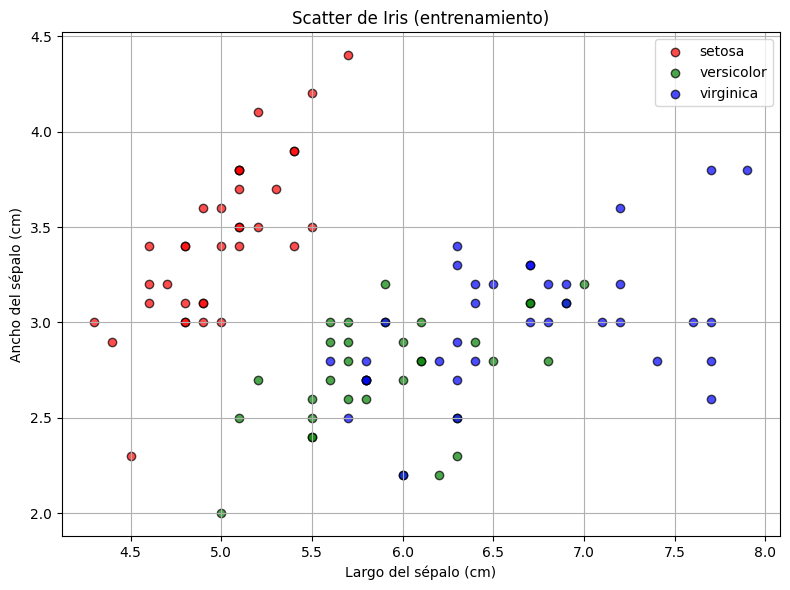

In [19]:
# Cargar dataset de iris
iris = datasets.load_iris()
X = iris.data[:, :2]  # Solo dimensiones del sépalo: largo y ancho
y = iris.target
target_names = iris.target_names

# Separar datos en entrenamiento y testeo (70/30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Graficar los datos
plt.figure(figsize=(8, 6))
colors = ['red', 'green', 'blue']
for i, color in zip(range(len(target_names)), colors): # zip une ambos parametros en una tupla {a, b}
    plt.scatter(X_train[y_train == i, 0], X_train[y_train == i, 1],
                label=target_names[i], alpha=0.7, edgecolors='k', color=color)
plt.xlabel("Largo del sépalo (cm)")
plt.ylabel("Ancho del sépalo (cm)")
plt.title("Scatter de Iris (entrenamiento)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


🔍 ¿Qué información se puede obtener de este grafico?

- Setosa (rojo) está bastante separada de las otras dos especies. Esto sugiere que será fácil de clasificar usando estas dos variables. Tiene sentido ya que en teoria Setosa suele tener sépalos más anchos y cortos por lo que se diferencia de los otros dos.

- Versicolor y virginica se superponen un poco más, lo que indica que podrían confundirse entre sí usando solo el sépalo.



----
## (b) Clasificación LDA

- Implementar un algoritmo de LDA a partir de las dimensiones del sépalo para clasificar las plantas de Iris. El código debe estar estructurado de la siguiente manera:

    ```python
    class LDA:
        def __init__(self, ...):
            # Inicializar atributos y declarar hiperparámetros

        def fit(self, X, y):
            # Etapa de entrenamiento

        def predict_proba(self, X):
            # Etapa de testeo soft

        def predict(self, X):
            # Etapa de testeo hard
    ```

- Superponer al scatter las medias y las covarianzas de cada gaussiana (una curva de nivel) del modelo de LDA.

- Superponer al scatter las fronteras de decisión.

    **Nota**: Funciones como `meshgrid` (numpy) y `contour`(matplotlib) pueden ser útiles para graficar las fronteras.

- Reportar el accuracy de testeo.


**🧠 ¿Qué es LDA?**

**LDA (Linear Discriminant Analysis)** es un modelo de clasificación que sirve para agrupar objetos en diferentes clases.  
En este caso, se puede usar para clasificar flores en tres especies distintas (*setosa*, *versicolor*, *virginica*), utilizando características como el largo y el ancho del sépalo.

**🪄 ¿Qué hace LDA?**

LDA busca una **línea (o plano)** que **separe lo mejor posible a las clases** usando la información disponible. Para lograrlo:

- Analiza los datos de cada clase y calcula sus **medias**.
- Supone que los datos de cada clase siguen una **distribución normal (gaussiana)**.
- También asume que todas las clases comparten la **misma matriz de covarianza**.
- Calcula **fronteras de decisión lineales** que separan las clases.

**🖼️ Ejemplo visual**

Si tuviéramos un gráfico con puntos de colores (rojos, verdes y azules, una clase por color),  
LDA dibujaría **líneas rectas** para separar lo mejor posible cada grupo de puntos.


**✅ Lo más importante**

- Sirve para **clasificar elementos** en clases conocidas.
- Es **rápido y simple** de implementar.
- Las **fronteras entre clases son rectas**.
- Funciona bien cuando las clases **no se superponen mucho** y tienen **formas similares**.


**💡 ¿Qué aprende LDA?**

LDA entrena un modelo generativo que estima:

- La **media** de cada clase: \( \mu_k \)
- La **probabilidad (prior)** de cada clase: \( c_k \)
- Una **única matriz de covarianza compartida**: \( \Sigma \)

Con esta información, LDA puede calcular cuál es la clase más probable para un nuevo dato \( x \).


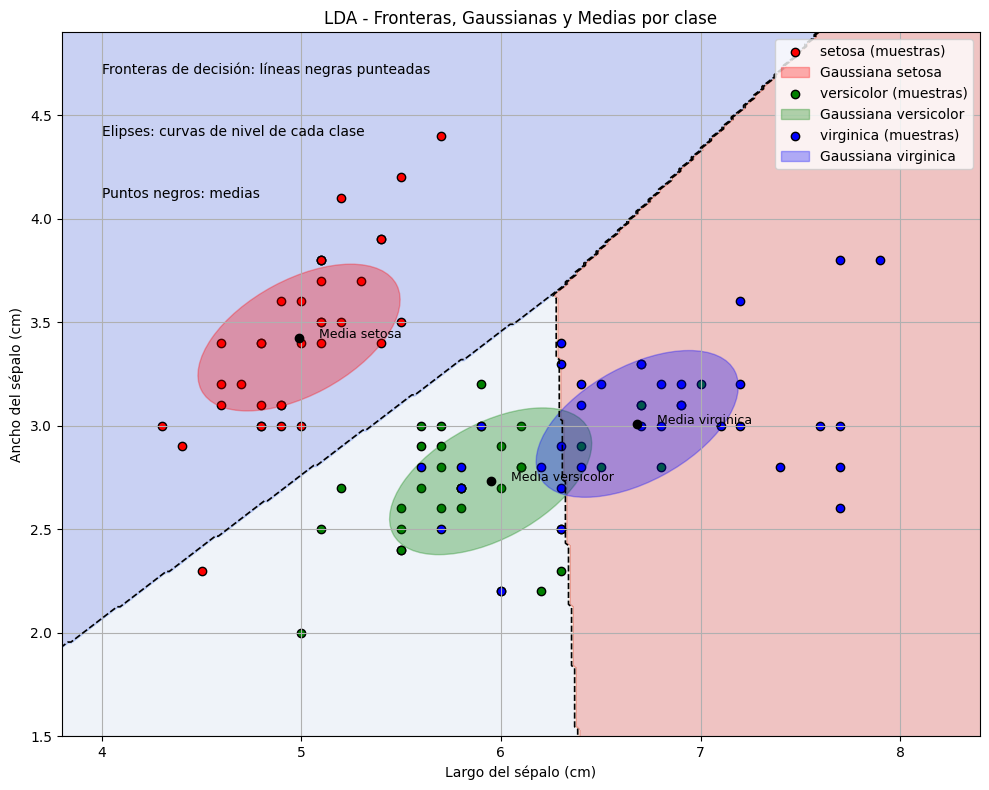


### 📌 Accuracy: $ 0.76 $


In [ ]:
class LDA:
    def __init__(self):
        self.means_ = None # las medias de cada clase.
        self.cov_ = None # la matriz de covarianza común (porque LDA supone que es la misma en todas las clases)
        self.priors_ = None # las probabilidades de cada clase
        self.classes_ = None # las clases posibles (0, 1, 2 para Iris)

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)
        n_features = X.shape[1]
        self.means_ = np.zeros((n_classes, n_features))
        self.priors_ = np.zeros(n_classes)

        # Calcular medias y prior
        for idx, c in enumerate(self.classes_):
            X_c = X[y == c]
            self.means_[idx] = np.mean(X_c, axis=0)
            self.priors_[idx] = X_c.shape[0] / X.shape[0] # calculo la proporción de esa clase en los datos

        # Calcular covarianza compartida
        cov = np.zeros((n_features, n_features))
        for idx, c in enumerate(self.classes_):
            X_c = X[y == c]
            cov += np.cov(X_c.T, bias=True) * X_c.shape[0]
        # covarianza total compartida: cómo se dispersan los datos en general. 
        # LDA supone que todas las clases comparten esta matriz.
        self.cov_ = cov / X.shape[0]

    def predict_proba(self, X):
        inv_cov = inv(self.cov_)
        probs = []
        for x in X:
            class_probs = []
            for idx, c in enumerate(self.classes_):
                mean = self.means_[idx]
                log_prior = np.log(self.priors_[idx])
                log_likelihood = -0.5 * (x - mean).T @ inv_cov @ (x - mean)
                class_probs.append(log_likelihood + log_prior)
            probs.append(class_probs)
        return np.array(probs)

    def predict(self, X):
        #  Toma la clase con mayor puntaje (es decir, la más probable) y la elige como predicción.
        return np.argmax(self.predict_proba(X), axis=1) 

# --------------------------------------- 
# Entrenar modelo LDA
lda = LDA()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)

# --------------------------------------- 
# Gráfico: fronteras + gaussianas
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
# meshgrid es para crear una grilla de puntos
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))

plt.figure(figsize=(10, 8))

# Fronteras de decisión (líneas de color)
Z = lda.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
contour = plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.contour(xx, yy, Z, levels=np.unique(Z), colors='k', linewidths=1.2, linestyles='--')

# Puntos y gaussianas
for idx, color in zip(lda.classes_, colors):
    X_class = X_train[y_train == idx]
    plt.scatter(X_class[:, 0], X_class[:, 1], label=f"{target_names[idx]} (muestras)", color=color, edgecolor='k')

    # Medias
    mean = lda.means_[idx]
    plt.plot(mean[0], mean[1], 'o', color='black', markersize=6)
    plt.text(mean[0]+0.1, mean[1], f"Media {target_names[idx]}", fontsize=9, color='black')

    # Elipse (curva de nivel de la gaussiana)
    cov = lda.cov_
    vals, vecs = np.linalg.eigh(cov)
    angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    ell = Ellipse(xy=mean, width=2*np.sqrt(vals[0]), height=2*np.sqrt(vals[1]),
                  angle=angle, color=color, alpha=0.3, label=f"Gaussiana {target_names[idx]}")
    plt.gca().add_patch(ell)

# Anotación general
plt.text(x_min + 0.2, y_max - 0.2, "Fronteras de decisión: líneas negras punteadas", fontsize=10, color='black')
plt.text(x_min + 0.2, y_max - 0.5, "Elipses: curvas de nivel de cada clase", fontsize=10, color='black')
plt.text(x_min + 0.2, y_max - 0.8, "Puntos negros: medias", fontsize=10, color='black')

plt.xlabel("Largo del sépalo (cm)")
plt.ylabel("Ancho del sépalo (cm)")
plt.title("LDA - Fronteras, Gaussianas y Medias por clase")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

accuracy = accuracy_score(y_test, y_pred)

display(Markdown(f"""
### 📌 Accuracy: $ {accuracy:.2f} $
"""))



**Medias y covarianzas**

Cuando se hace un modelo como LDA, se calcula:

- La media de cada clase: es el “centro” de los puntos de esa clase.

- Una matriz de covarianza (en LDA es compartida): define cómo se dispersan los datos.

El enunciado dice que hay que dibujar esas medias y esa dispersión encima del scatter plot. Esto se suele hacer con una elipse que representa una “curva de nivel” de la gaussiana (como un contorno de igual densidad). Tambien se puede mostrar utilizando la funcion `multivariate_normal` de `scipy.stats` que es mas preciso.

**Fronteras de decision** 

LDA crea fronteras (líneas) que separan el espacio en regiones para cada clase.

- Frontera de decisión = línea que separa a setosa de versicolor, o versicolor de virginica.




---
## (c) Síntesis
Utilizando el modelo LDA, generar 30 muestras sintéticas y graficarlas junto a las fronteras. Representar las diferentes especies de Iris con colores distintos.

**Nota**: Tener en cuenta que, además de las medias y varianzas, se deben utilizar las probabilidades ck aprendidas durante el entrenamiento.Funciones como `random.choice` y `random.multivariate_normal` (numpy) pueden ser útiles.


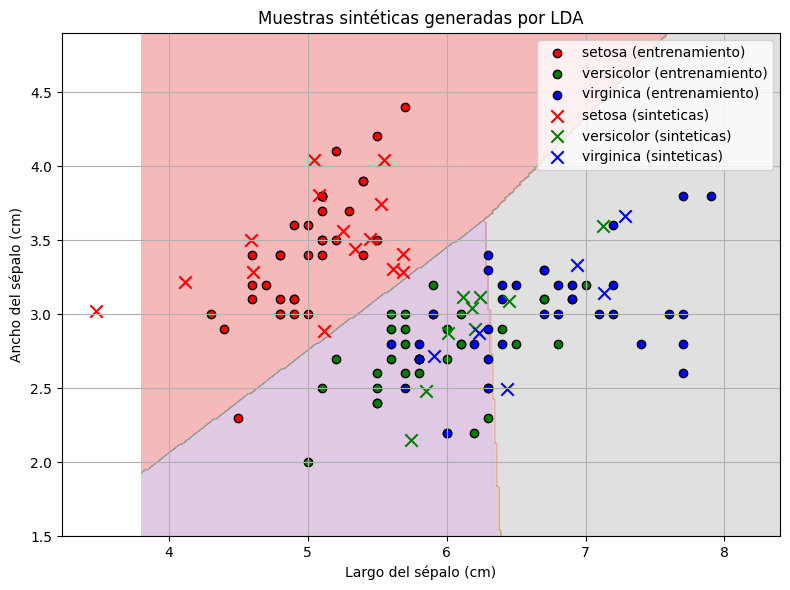

In [43]:
# Semilla para reproducibilidad
np.random.seed(42)

# Generar 30 muestras sintéticas usando la distribución aprendida
n_samples = 30
synthetic_X = []
synthetic_y = []

for _ in range(n_samples):
    # Elegir clase según prior
    clase = np.random.choice(lda.classes_, p=lda.priors_)
    mean = lda.means_[clase]
    cov = lda.cov_
    sample = np.random.multivariate_normal(mean, cov)
    synthetic_X.append(sample)
    synthetic_y.append(clase)

synthetic_X = np.array(synthetic_X)
synthetic_y = np.array(synthetic_y)

# Gráfico con las muestras sintéticas
plt.figure(figsize=(8, 6))
Z = lda.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.3, cmap="Set1")

# Entrenamiento real
for idx, color in zip(lda.classes_, colors):
    data = X_train[y_train == idx]
    plt.scatter(data[:, 0], data[:, 1], label=f"{target_names[idx]} (entrenamiento)", color=color, edgecolor='k')

# Muestras sintéticas
for idx, color in zip(lda.classes_, colors):
    data = synthetic_X[synthetic_y == idx]
    plt.scatter(data[:, 0], data[:, 1], marker='x', color=color, s=80, label=f"{target_names[idx]} (sinteticas)")

plt.xlabel("Largo del sépalo (cm)")
plt.ylabel("Ancho del sépalo (cm)")
plt.title("Muestras sintéticas generadas por LDA")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



---
## (d) Discriminante cuadrático
Repetir los incisos (b) y (c) utilizando un algoritmo QDA.

La frase:

> “Dada la similitud entre ambos algoritmos, se recomienda modificar el código anterior utilizando un hiperparámetro que indique si estamos en un análisis lineal o cuadrático.”

se refiere a que LDA y QDA comparten una estructura muy parecida:

| Elemento	| LDA	| QDA |
|---|---|---|
| Medias| 	✅ una por clase| 	✅ una por clase| 
| Covarianza	| ❗ única para todas las clases| 	✅ una por clase| 
| Ecuación de decisión	| Lineal	| Cuadrática| 
| Priors| 	✅ sí, en ambos	| ✅ sí, en ambos| 

🧠 ¿Dónde podemos aplicar ese hiperparámetro?
En el código que se implemento, hay una clase llamada DiscriminantAnalysis que recibe en su constructor un hiperparámetro llamado mode:

```python
class DiscriminantAnalysis:
    def __init__(self, mode='linear'):  # 👈 acá está el hiperparámetro
        self.mode = mode  # puede ser 'linear' (LDA) o 'quadratic' (QDA)
```

Un **QDA (Quadratic Discriminant Analysis)** es un algoritmo de clasificación supervisada, muy parecido a LDA, pero un poco más flexible porque asume que los datos de cada clase siguen una distribución normal (gaussiana), pero cada clase tiene su propia forma (covarianza)

**🛠️ ¿Cómo funciona QDA?**

Aprende:

- Una media para cada clase: qué tan centrados están los datos.

- Una matriz de covarianza por clase: cómo se dispersan los datos en cada grupo.

- La probabilidad (prior) de cada clase.

- Calcula la probabilidad de que un nuevo dato pertenezca a cada clase, y elige la más probable.

- Las fronteras de decisión entre clases ya no son líneas rectas como en LDA, sino curvas (por eso “cuadrático”).

Es recomendable usar QDA cuando las clases no se separan con una línea, que es el caso de versicolor y virginica.

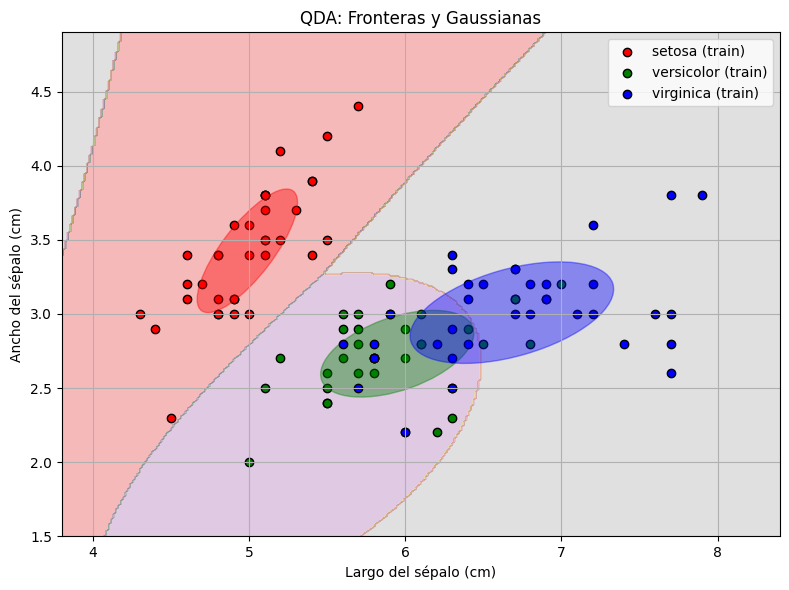


### 📌 Accuracy: $ 0.71 $


In [48]:
# Clase LDA/QDA combinada
class DiscriminantAnalysis:
    def __init__(self, mode='linear'):
        self.mode = mode  # 'linear' para LDA, 'quadratic' para QDA
        self.means_ = None
        self.priors_ = None
        self.classes_ = None
        self.cov_ = None
        self.class_covs_ = None

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)
        n_features = X.shape[1]
        self.means_ = np.zeros((n_classes, n_features))
        self.priors_ = np.zeros(n_classes)

        self.class_covs_ = []
        for idx, c in enumerate(self.classes_):
            X_c = X[y == c]
            self.means_[idx] = np.mean(X_c, axis=0)
            self.priors_[idx] = X_c.shape[0] / X.shape[0]
            self.class_covs_.append(np.cov(X_c.T, bias=True))

        if self.mode == 'linear':
            # Calcular covarianza compartida
            cov = np.zeros((n_features, n_features))
            for idx, c in enumerate(self.classes_):
                X_c = X[y == c]
                cov += np.cov(X_c.T, bias=True) * X_c.shape[0]
            self.cov_ = cov / X.shape[0]

    def predict_proba(self, X):
        probs = []
        for x in X:
            class_probs = []
            for idx, c in enumerate(self.classes_):
                mean = self.means_[idx]
                if self.mode == 'linear':
                    cov = self.cov_
                else:
                    # QDA necesita la matriz de covarianza individual por clase.
                    cov = self.class_covs_[idx]
                inv_cov = inv(cov)
                log_prior = np.log(self.priors_[idx])
                log_likelihood = -0.5 * (x - mean).T @ inv_cov @ (x - mean) - 0.5 * np.log(det(cov))
                class_probs.append(log_likelihood + log_prior)
            probs.append(class_probs)
        return np.array(probs)

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

# Entrenar modelo QDA
qda = DiscriminantAnalysis(mode='quadratic')
qda.fit(X_train, y_train)
y_pred_qda = qda.predict(X_test)

# Gráfico de fronteras y gaussianas
Z_qda = qda.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z_qda, alpha=0.3, cmap='Set1')

for idx, color in zip(qda.classes_, colors):
    data = X_train[y_train == idx]
    plt.scatter(data[:, 0], data[:, 1], label=f"{target_names[idx]} (train)", color=color, edgecolor='k')

    mean = qda.means_[idx]
    cov = qda.class_covs_[idx]
    vals, vecs = np.linalg.eigh(cov)
    angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    ell = Ellipse(xy=mean, width=2*np.sqrt(vals[0]), height=2*np.sqrt(vals[1]),
                  angle=angle, color=color, alpha=0.4)
    plt.gca().add_patch(ell)

plt.xlabel("Largo del sépalo (cm)")
plt.ylabel("Ancho del sépalo (cm)")
plt.title("QDA: Fronteras y Gaussianas")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calcular accuracy
accuracy_qda = accuracy_score(y_test, y_pred_qda)
display(Markdown(f"""
### 📌 Accuracy: $ {accuracy_qda:.2f} $
"""))



---
## (e) K vecinos más cercanos
Repetir el inciso (b) utilizando un algoritmo KNN con K = 6

**Nota:** No incluir curvas de nivel asociadas a medias y covarianzas, ya que aquí no corresponden.


**KNN (K-Nearest Neighbors)** es un algoritmo de clasificación no paramétrico y basado en instancias.

> 📌 Idea básica: Para saber a qué clase pertenece un punto nuevo, hay que mirar los K vecinos más cercanos (los puntos más parecidos) y elegir la clase que más se repite entre ellos.

**🧠 ¿Cómo funciona?**

- Guarda todos los datos de entrenamiento.

- Para clasificar un nuevo punto:

    - Calcula la distancia entre ese punto y todos los del conjunto de entrenamiento.

    - Elige los K más cercanos.

- Hace un "voto mayoritario" entre las clases de esos K vecinos.

- Le asigna al nuevo punto la clase más común entre sus vecinos.

**🎯 Parámetro clave: K**
- K = 1: muy sensible al ruido (puede sobreajustar).

- K muy grande: puede ser demasiado general (subajuste).

**🧪 ¿Cuándo usar KNN?**
- Cuando se tiene datos bien distribuidos y no se quiere asumir una forma específica de las clases (como gaussianas).

- Cuando el dataset no es enorme (porque KNN guarda todos los datos, no entrena nada).


Se planteo el calculo del algoritmo KNN manualmente pero tambien se podria utilizar la funcion: [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

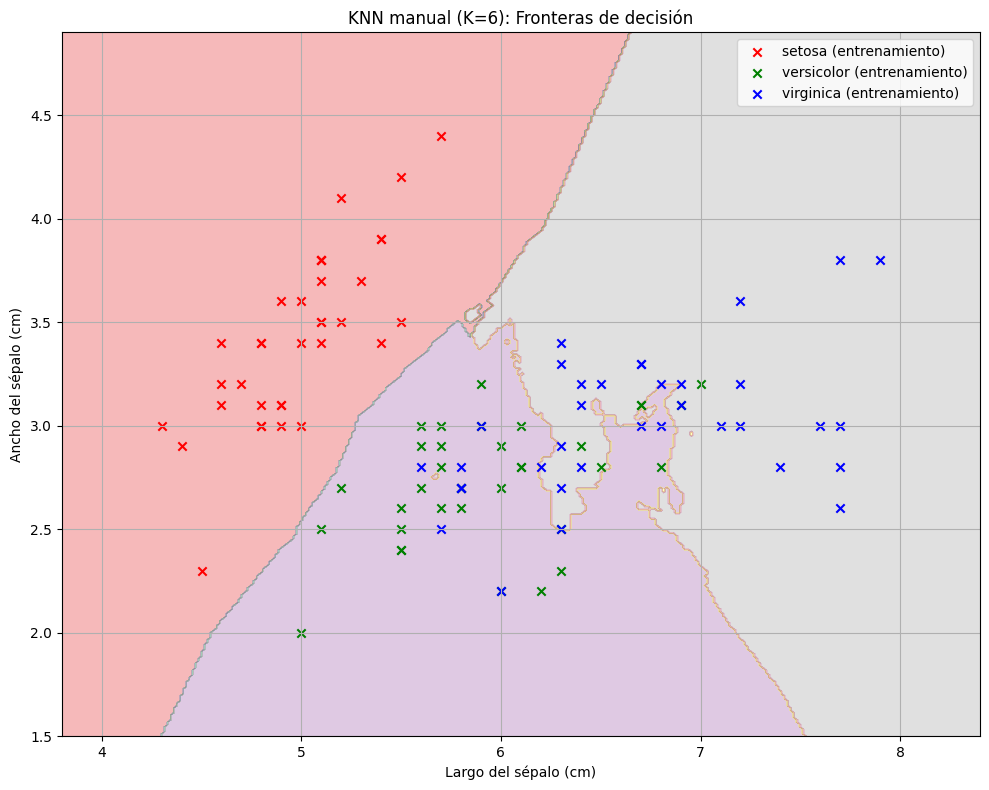


### 📌 Accuracy: $ 0.84 $


In [54]:
def knn_predict(X_train, y_train, X_test, k=6):
    y_pred = []
    for x in X_test:
        # Calcular distancias euclídeas a todos los puntos de entrenamiento
        distances = np.linalg.norm(X_train - x, axis=1)
        # Obtener los índices de los k vecinos más cercanos
        k_indices = np.argsort(distances)[:k]
        # Obtener las clases de los k vecinos
        k_labels = y_train[k_indices]
        # Votar por la clase más común
        most_common = mode(k_labels, keepdims=False).mode
        y_pred.append(most_common)
    return np.array(y_pred)

# Usar función para predecir sobre el set de testeo
y_pred_knn_manual = knn_predict(X_train, y_train, X_test, k=6)


# Graficar las fronteras
Z_knn_manual = knn_predict(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k=6).reshape(xx.shape)
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z_knn_manual, alpha=0.3, cmap='Set1')

for idx, color in zip(np.unique(y_train), colors):
    data = X_train[y_train == idx]
    plt.scatter(data[:, 0], data[:, 1], label=f"{target_names[idx]} (entrenamiento)", color=color, marker='x')

plt.xlabel("Largo del sépalo (cm)")
plt.ylabel("Ancho del sépalo (cm)")
plt.title("KNN manual (K=6): Fronteras de decisión")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calcular accuracy
accuracy_knn_manual = accuracy_score(y_test, y_pred_knn_manual)
display(Markdown(f"""
### 📌 Accuracy: $ {accuracy_knn_manual:.2f} $
"""))


---
## Extra: Plot para comparar los 3 metodos: LDA, QDA y KNN

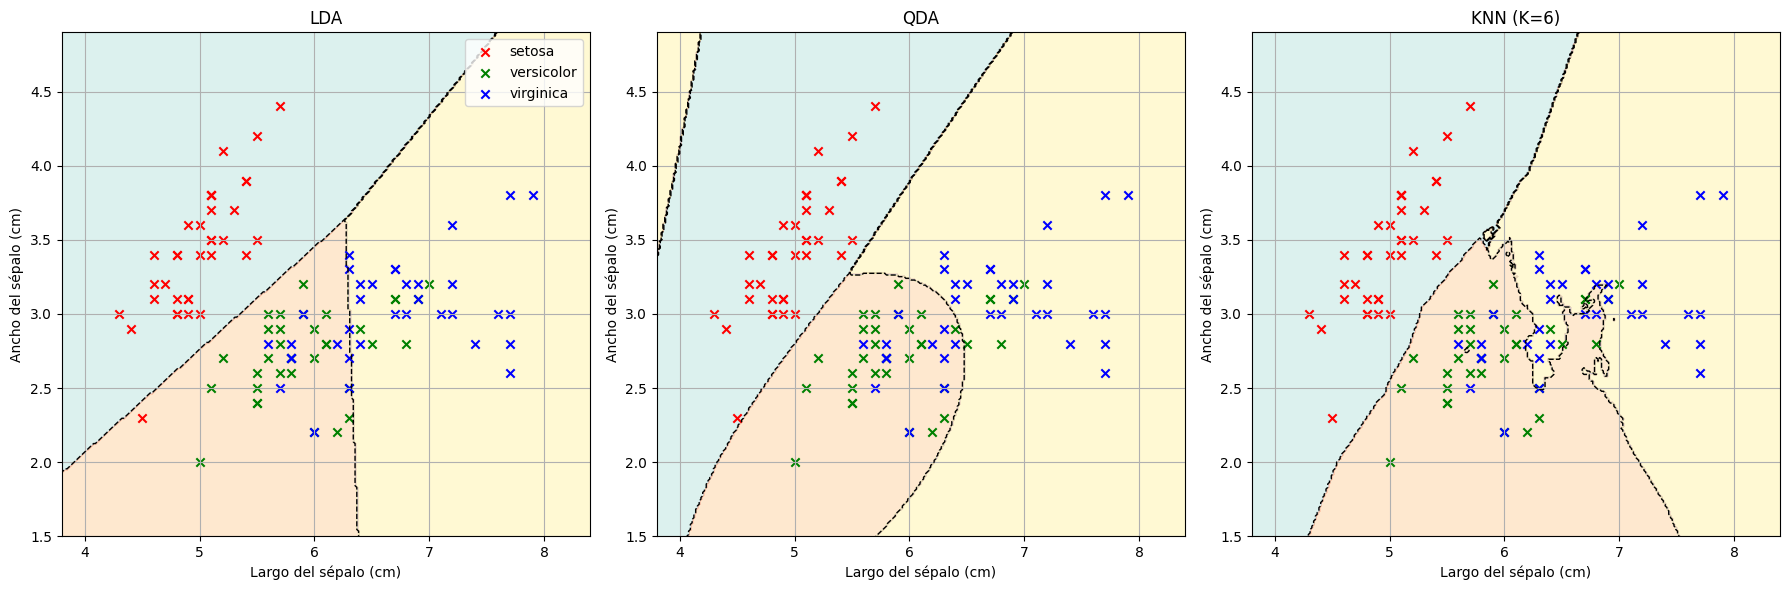


### 📌 Accuracy LDA: $ 0.76 $
### 📌 Accuracy QDA: $ 0.71 $
### 📌 Accuracy KNN (k=6): $ 0.84 $


In [56]:
# Calcular predicciones en la grilla para los tres métodos
Z_lda = lda.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
Z_qda = qda.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
Z_knn_manual = knn_predict(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k=6).reshape(xx.shape)

# Crear subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
titles = ['LDA', 'QDA', 'KNN (K=6)']
Zs = [Z_lda, Z_qda, Z_knn_manual]

for ax, Z, title in zip(axes, Zs, titles):
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='Set3')
    ax.contour(xx, yy, Z, levels=np.unique(Z), colors='k', linewidths=1.0, linestyles='--')
    
    for idx, color in zip(np.unique(y_train), colors):
        data = X_train[y_train == idx]
        ax.scatter(data[:, 0], data[:, 1], color=color, label=target_names[idx], marker='x')

    ax.set_title(title)
    ax.set_xlabel("Largo del sépalo (cm)")
    ax.set_ylabel("Ancho del sépalo (cm)")
    ax.grid(True)

axes[0].legend(loc='upper right')
plt.tight_layout()
plt.show()

# Comparar accuracy
display(Markdown(f"""
### 📌 Accuracy LDA: $ {accuracy:.2f} $
### 📌 Accuracy QDA: $ {accuracy_qda:.2f} $
### 📌 Accuracy KNN (k=6): $ {accuracy_knn_manual:.2f} $
"""))
